In [2]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# INPUT
# EFAS historical 6 hourly data
# ERA5 data



In [ ]:
# USER CONFIGURATION
EFASDIR_HIST="/home/zappa/work_big/EFAS/output"

# Name Pattern of EFAS data, * reflects different years
fname_pat=f"{EFASDIR_HIST}/efas_italy_*.nc"

# starting and last year to be analysed
sy=1993
ly=2023

# grid point of river point to be anlaysed (here Panaro near Modena)
tlat=44.65
tlon=10.99

#print(fname_pat)


In [4]:
# OPEN EFAS data as xarray
#dataset = xr.open_mfdataset(fname_pat, combine='by_coords').sel(lat=slice(45.5, 44), lon=slice(10.5, 12))
dataset = xr.open_mfdataset(fname_pat, combine='by_coords')
# print(dataset)


Plot a map for a day associated with Panaro flooding near Modena

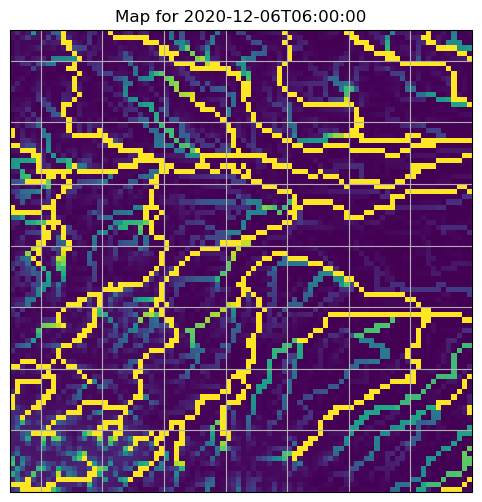

In [5]:

# Access variables within the dataset
variable = dataset['dis06']

# Select the data for the specific time step you want to plot
time_step = '2020-12-06T06:00:00'  # Example time step
data_for_time_step = dataset.sel(time=time_step)

# Extract longitude, latitude, and variable data
lon = data_for_time_step['lon']
lat = data_for_time_step['lat']
variable = data_for_time_step['dis06']  # Replace 'your_variable' with the name of your variable

# Plot the map
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the variable on the map
plt.pcolormesh(lon, lat, variable, transform=ccrs.PlateCarree(), cmap='viridis',vmin=0,vmax=25)
plt.xlim(tlon-2, tlon+2)  # Set longitude range
plt.ylim(tlat-1, tlat+1)  # Set latitude range

# Add coastlines, gridlines, and title
ax.coastlines()
ax.gridlines()
plt.title(f'Map for {time_step}')
plt.show()


Look at time series

In [6]:
# extract time series Panaro

near_lat=dataset['lat'].sel(lat=tlat,method='nearest').values
near_lon=dataset['lon'].sel(lon=tlon,method='nearest').values
vd=dataset['dis06'].sel(lat=near_lat,lon=near_lon)
vv=vd.values


[3.0532227 3.0375977 3.022461  ... 2.3945312 2.3935547 2.397461 ]


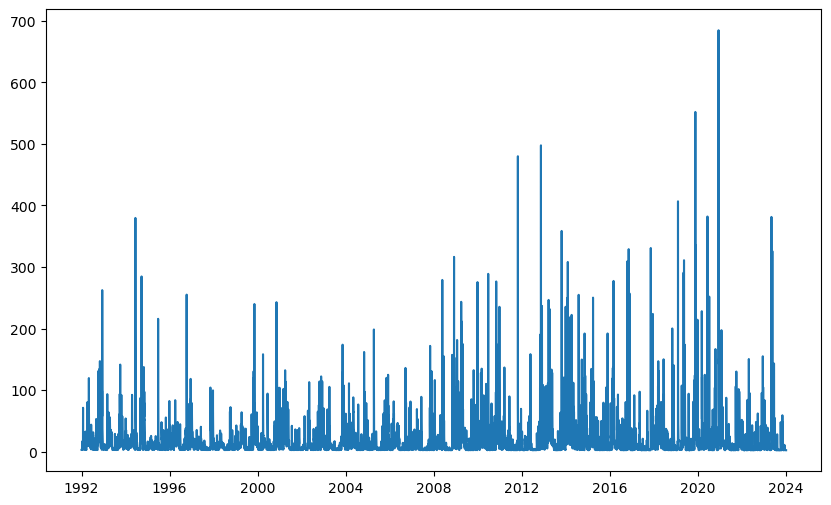

In [7]:
# plot time series for full period
plt.figure(figsize=(10,6))
plt.plot(dataset.time.values,vv)


In [8]:
# mean seasonality
daily_means = vd.groupby('time.dayofyear').mean(dim='time')
daily_max = vd.groupby('time.dayofyear').max(dim='time')




In [9]:


window_size = 31  # Adjust window size as needed
smoothed_means = daily_means.rolling(dayofyear=window_size, center=True).mean()
smoothed_max = daily_max.rolling(dayofyear=window_size, center=True).mean()



Text(0.5, 0, 'Day of year')

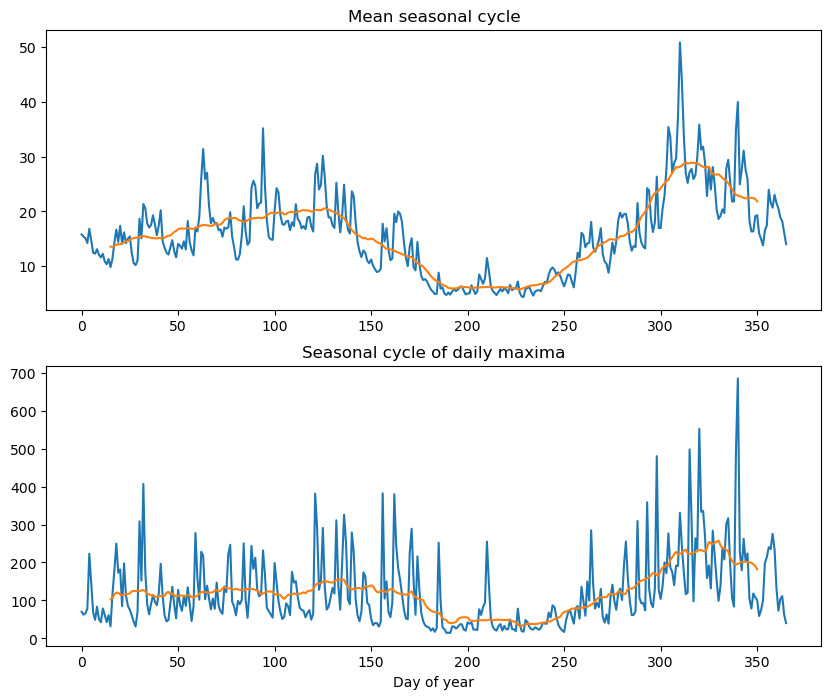

In [10]:

plt.figure
fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # 2 rows, 1 column
axs[0].plot(daily_means)
axs[0].plot(smoothed_means)
axs[0].set_title('Mean seasonal cycle')

axs[1].plot(daily_max)
axs[1].plot(smoothed_max)
axs[1].set_title('Seasonal cycle of daily maxima')
axs[1].set_xlabel('Day of year')


In [11]:
# identify extreme events
# percentiles
prcth=99.9
vv_prc=np.percentile(vv, prcth)
vv_up=vv[vv>vv_prc]
print(vv_prc, np.sort(vv_up))

# events
def find_events(data, threshold):
    events = []
    event_start = None
    event_values = []  # List to store values within each event
    gap = 0
    
    # Loop through the data array
    for i, value in enumerate(data):
        if value > threshold:
            # Start of a new event
            gap=0
            if event_start is None:
                event_start = i
            event_values.append(value)
            #print(event_values)
        else:
            # End of an event
            if np.all(data[i:i+3]<threshold) and event_start is not None:
                events.append((event_start, i-1, event_values))  # Append the event start and end indices
                event_start = None  # Reset event start index
                event_values = []  # Reset event_values    

    # Check if an event extends to the end of the array
    if event_start is not None:
        events.append((event_start, len(data)-1), event_values)  # Append the event start and end indices
    
    return events




277.4000854492189 [277.41602 279.04565 280.00244 280.59094 281.53247 283.95215 284.71997
 288.93555 290.98853 292.17383 293.7588  296.646   298.56226 300.67932
 301.66846 308.24255 309.25928 311.07373 312.56055 313.71582 315.85303
 316.50098 320.57812 324.35486 325.62256 325.80957 329.05786 330.9109
 333.36865 335.5459  337.81274 358.63867 360.69116 364.7666  379.74316
 381.41895 382.06836 406.76196 426.45605 455.4995  479.95605 490.65137
 497.6714  498.9402  551.9165  618.1697  684.5786 ]


Text(0.5, 1.0, 'Events exceeding 99.9-ptile, 277.40 m^3/s')

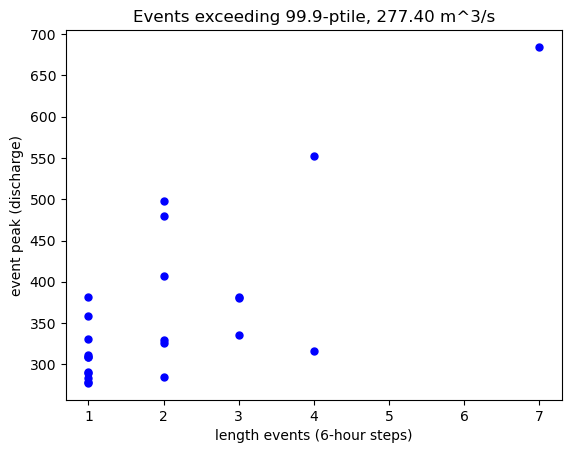

In [12]:
iv_event=find_events(vv,vv_prc)

# Convert events to a pandas DataFrame
df_events = pd.DataFrame(iv_event)
event_length=df_events[2].apply(len)
event_max=df_events[2].apply(max)

plt.figure
plt.plot(event_length,event_max,marker='o', linestyle='None', markersize=5, color='blue')
plt.xlabel('length events (6-hour steps)')
plt.ylabel('event peak (discharge)')
plt.title(f'Events exceeding {prcth}-ptile, {vv_prc:,.2f} m^3/s')

Read ERA data

In [62]:
ext='6hrs_full_sfc_{year}_70_-50_10_55'
data_files = {
    ('surface_pressure', 'SP')
}
years = range(sy, ly+1)

# Loop over each file and variable name
# ONLY WORKS WITH 1 VARIABILE FOR NOW
for variable, variable_name in data_files:
    file_paths = [f"{ERA5dir}/{variable}/6hrs/ERA5_{variable}_{ext}.nc".format(year=year) for year in years]
    ds1 = xr.open_mfdataset(file_paths,combine='by_coords')
    vdata=ds1[variable_name]


('lat', 'lon')


Look at individual events

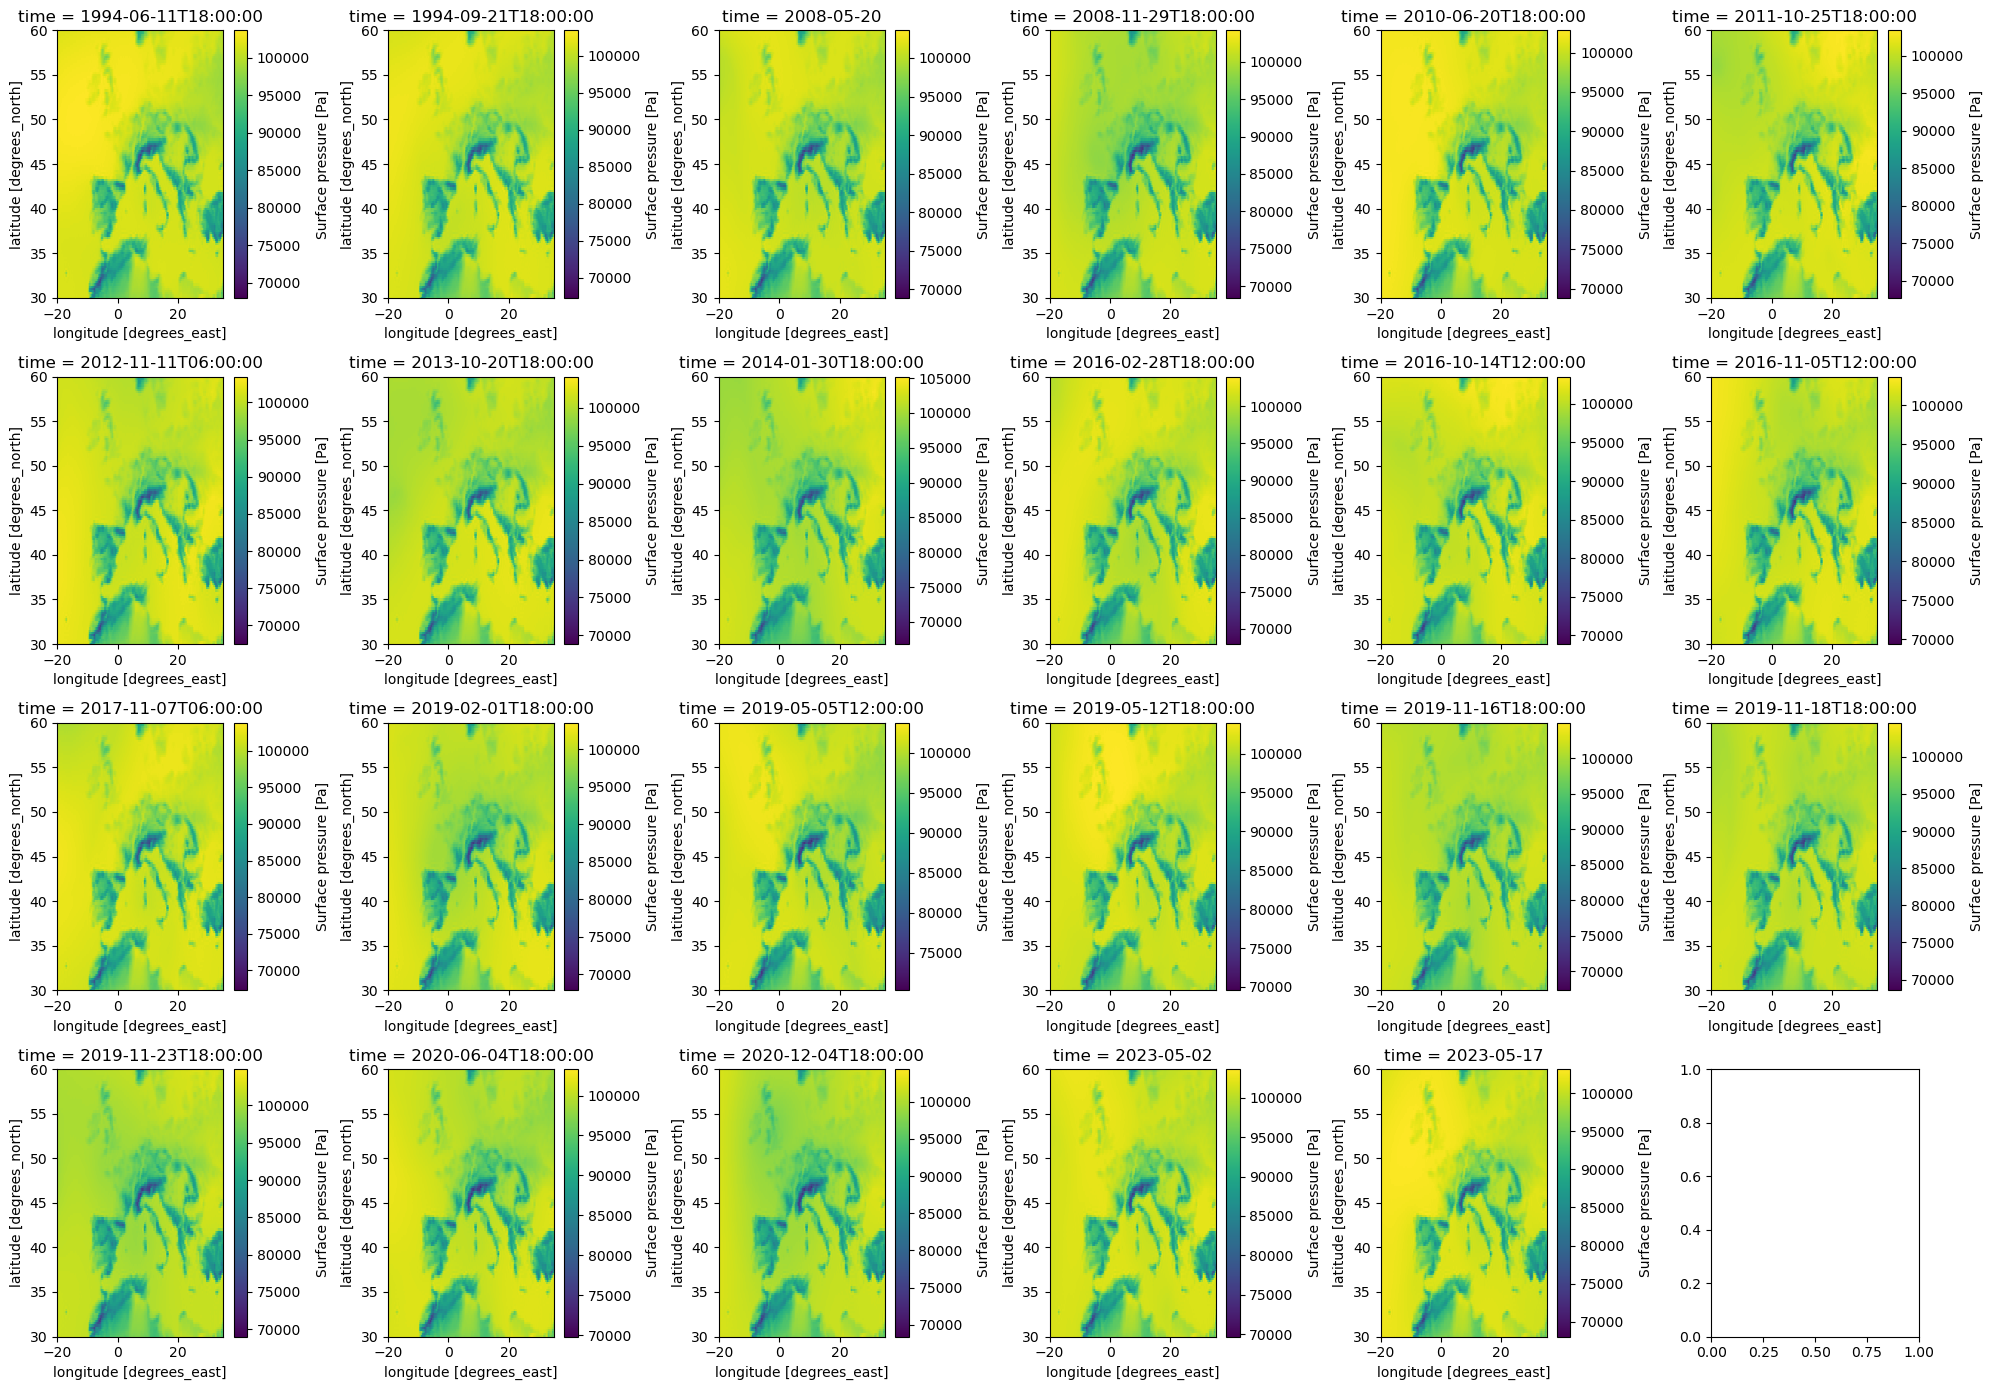

In [83]:
vdata_events=vdata.isel(time=df_events[0])

# Determine the number of time steps
num_times = len(vdata_events.time)

# Calculate the number of rows and columns for the subplot grid
num_rows = int(num_times ** 0.5)
num_cols = (num_times + num_rows - 1) // num_rows

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 14))

# Loop through each time step and plot in the corresponding subplot
for i, time in enumerate(vdata_events.time):
    row = i // num_cols
    col = i % num_cols

    # Select data for the current time step
    data_at_time = vdata_events.sel(time=time)

    # Plot in the corresponding subplot    
    axes[row, col].set_title(f'{time}')
    data_at_time.plot(ax=axes[row, col])

    # Set latitude and longitude range
    axes[row, col].set_xlim(-20, 35)
    axes[row, col].set_ylim(30, 60)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()



In [87]:


def composite_events(vdata, df_events):
    era_events=[]
    for event_start in df_events[0]:
        #print(event_start)
        # Extract data for the event time steps
        era_events_tmp = vdata.isel(time=event_start)
        #print(era_events_tmp.dims)
        # Calculate the average of variable B for the event
        era_events.append(era_events_tmp)
    era_events_concatenated = xr.concat(era_events, dim="event") 
    vdata_clim=vdata.mean(dim='time')
    average_era_events = era_events_concatenated.mean(dim="event")
    average_era_events_anom=average_era_events-vdata_clim

    return average_era_events_anom

# List of variable names you want to extract
ext='6hrs_full_sfc_{year}_70_-50_10_55'
data_files = {
    ('surface_pressure', 'SP')
}
years = range(1992, 2024)

# compute composite means    
comp_mean=composite_events(vdata, df_events)
    

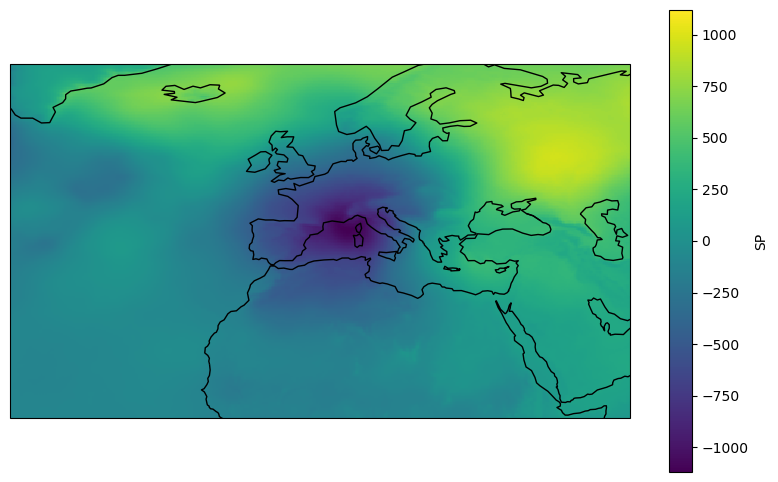

In [88]:

# Plot composite mean anomaly the variable on the map
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data array
comp_mean.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')

# Add coastlines and gridlines
ax.coastlines()
#ax.gridlines()

# Show the plot
plt.show()

<xarray.DataArray 'SP' (lat: 241, lon: 421)> Size: 406kB
dask.array<mean_agg-aggregate, shape=(241, 421), dtype=float32, chunksize=(241, 421), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 3kB -50.0 -49.75 -49.5 -49.25 ... 54.5 54.75 55.0
  * lat      (lat) float64 2kB 70.0 69.75 69.5 69.25 ... 10.75 10.5 10.25 10.0


1) Leggere SLP/TCWV/Z500/Precip ERA5 e fare mean composite / SOM clustering (18 eventi?)
2) Guardare stagionalità media portata, accadimento eventi
3) Fittare GEV to Annual maxima ... ma con 30 punti ci facciamo poco.
4) Guardare dipendenza temporale eventi da posizione lungo corso d'acqua
5) Map tendency of annual maxima (Italy)
6) Composite centered-time evolution of event.
7) Pioggia su bacino idrografico
8) Dati di stazione (esistono per panaro)